In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn.init as nn_init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from preprocessing import MSC, MeanCenter, Autoscale, trans2absr
import math
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torchviz import make_dot
from SPanalysis import SpectralAnalysis
# Image display
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV
device = torch.device('cpu')
run_on_gpu = False
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('yes')
    run_on_gpu = True

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)


yes


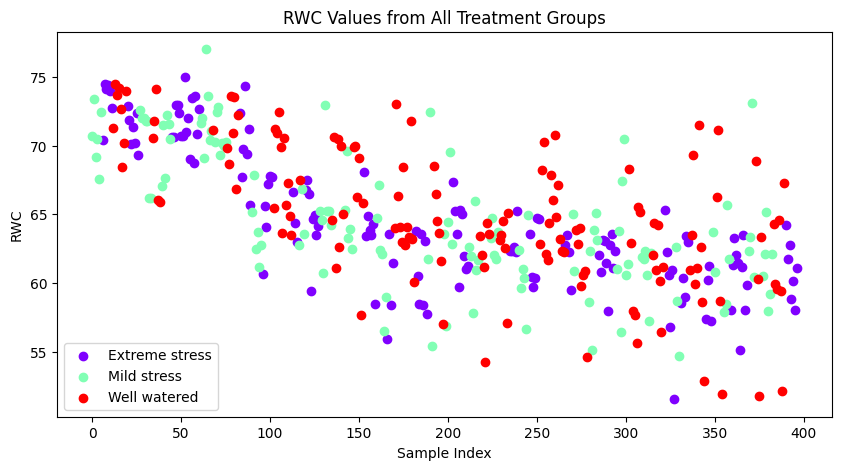

In [2]:
file_path =  'dataset\Hyperspectral\Combind_H_canopy.xlsx'   # Update with your file path
df = pd.read_excel(file_path)

# Group by Treatment
grouped = df.groupby('Treatment')

# Plot RWC values from all treatment groups with different colors
plt.figure(figsize=(10, 5))
colors = plt.cm.rainbow(np.linspace(0, 1, len(grouped)))

for (treatment, group), color in zip(grouped, colors):
    plt.scatter(group.index, group['RWC'], label=treatment, color=color)

plt.xlabel('Sample Index')
plt.ylabel('RWC')
plt.title('RWC Values from All Treatment Groups')
plt.legend()
plt.show()

In [2]:
#import data
dataset= 'dataset\Hyperspectral\Combind_H_canopy.xlsx' 
analysis = SpectralAnalysis(dataset,'PLSR')
analysis.preprocess_data()
def rwctocat(clss):
    if clss== 'Well watered':
        return 0
    elif clss== 'Mild stress':
        return 1
    else:
        return 2

X_train, y_train_reg, y_train_class, X_test, y_test_reg, y_test_class = analysis.X_train, analysis.y_train_reg.iloc[:,0],analysis.y_train_class,analysis.X_test,analysis.y_test_reg.iloc[:,0],analysis.y_test_class

y_train_class = y_train_class.astype('category')
y_test_class =  y_test_class.astype('category')
print(f'Training sample {X_train.shape[0]}')
print(f'Total spectra {X_train.shape[1]}')
print(f'Val sample {X_test.shape[0]}')
y_test_reg.shape

df_columns_name = (136,)
df_columns_name = (136,)
Training sample 2770
Total spectra 130
Val sample 1200


(1200,)

In [3]:
#version_1
class SpectralPatchEmbedding(nn.Module):
    """
    Embeds spectral data into patches with a specified embedding dimension.
    
    Parameters:
        patch_size (int): The size of each patch.
        embedding_dim (int): The dimensionality of the embedding output.
    """
    def __init__(self, patch_size: int, embedding_dim :int)-> None:
        super().__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim)

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # print(f'here {x.shape}')
        x = x.unfold(1, self.patch_size, self.patch_size)
        # print(f'after unfold {x.shape}')
        x = x.view(x.size(0), -1, self.patch_size)

        # print(f'after view {x.shape}')
        x = self.embedding(x)
        return x

class PositionalEncoding(nn.Module):
    """
    Adds a positional encoding to embedded spectral data.
    
    Parameters:
        d_model (int): The dimensionality of the model's input.
        max_len (int, optional): The maximum length of the input sequences. Defaults to 5000.
        base (float, optional): The base of the logarithm used in calculating the div_term. Defaults to 10000.0.
    """
    def __init__(self, d_model: int, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    '''
    FeatureExtractor: Extracts features from spectral data using a Transformer encoder.
    '''
    def __init__(self, num_features : int , patch_size : int , embedding_dim : int, num_heads : int, num_encoder_layers : int, 
                 dim_feedforward : int,activation_fn=F.relu)-> None:
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.patch_embedding = SpectralPatchEmbedding(patch_size, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward, activation=activation_fn,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        batch_size = inputs.size(0)
        #print(f'inputs= {inputs.shape}')
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        inputs = self.patch_embedding(inputs) #[batch_size,patches,embedding]
        # print(f'after patch_embedding= {inputs.shape}')
        inputs = torch.cat((cls_tokens, inputs), dim=1) #[batch_size,patches+ cls token,embedding]
        #print(f'after class token= {inputs.shape}')
        inputs = self.pos_encoder(inputs)
        output = self.transformer_encoder(inputs) #[batch_size,patches+ cls token,embedding]
        #print(f'after transformer= {output.shape}')
        return output

class ClassificationHead(nn.Module):
    '''
    ClassificationHead: Performs classification on features extracted from spectral data.
    Incorporates AdaptiveAvgPool1d for pooling over sequence dimension.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, num_classes: int
                 ,activation_fn=F.relu)-> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, num_classes)
        # Initialize AdaptiveAvgPool1d
        # Here, output size is set to 1 to pool across all sequence elements
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))
        self.activation=activation_fn

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        

        #print(f'in classification {inputs.shape}')
        
        # Apply adaptive pooling to reduce seq_len to 1
        x = self.adaptive_pool(inputs) 
        #print(f'in classification after pool {x.shape}')
        # Flatten the output for the linear layer
        x = torch.flatten(x, 1)  # Now x should be [batch_size, features= embedding//2 * patches * cls token]
        # Continue through the classification head
        #print(f'in classification after flat {x.shape}')
        x = self.activation(self.bn1(self.fc1(x)))
       
        x = self.dropout(x)
        x=self.activation(self.bn1(self.fc2(x)))
        x = self.fc3(x)
        # print(x.shape)
        #print(f'in classification after after flat {x.shape}')
        # Apply softmax to the output layer for classification probabilities
        return F.softmax(x, dim=1) 


class RegressionHead(nn.Module):
    '''
    RegressionHead: Performs regression on features extracted from spectral data.
    '''
    def __init__(self, input_features : int, hidden_features: int,embedding_dim: int, output_features: int,
                 activation_fn=F.relu)-> None:
        super(RegressionHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, hidden_features)
        self.bn1 = nn.BatchNorm1d(hidden_features)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_features, hidden_features)
        self.fc3 = nn.Linear(hidden_features, output_features)
        self.dropout2 = nn.Dropout(0.5)
        self.activation=activation_fn
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(embedding_dim//2))

    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        #print(f'inputs 1 shape in regression {inputs.shape}')
        x = self.adaptive_pool(inputs) # Assuming global average pooling over sequence dimension
        x = torch.flatten(x, 1)
        #print(f'x shape in regression {x.shape}')
        
        x = self.activation(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x= self.activation(self.bn1(self.fc2(x)))
        x = self.dropout2(x)
        #print(f'after regression= {x.shape}')
        x=self.fc3(x)
        return x

class CombinedModel(nn.Module):
    '''
    CombinedModel: Integrates FeatureExtractor, ClassificationHead, and RegressionHead.
    Allows optional bypass of ClassificationHead based on a flag.
    '''
    def __init__(self, num_features : int, patch_size : int, embedding_dim : int,
                 num_heads : int, num_encoder_layers : int, dim_feedforward : int,
                 hidden_features_class: int, num_classes: int, hidden_features_reg: int, output_features_reg: int,
                 use_classification : bool=True,activation_fn=F.relu)-> None:
        
        super().__init__()
        self.classification_input=((num_features//patch_size)+1)*(embedding_dim//2) #calculating classification inputs. +1 is the class token and //2 is for adaptive pooling factor
        if use_classification:
            regression_input= ((num_features//patch_size)+2)*(embedding_dim//2)
        else:
            regression_input= ((num_features//patch_size)+1)*(embedding_dim//2)
            
        self.feature_extractor = FeatureExtractor(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers, dim_feedforward,activation_fn=F.gelu)
        self.use_classification = use_classification
        self.classification_head = ClassificationHead(self.classification_input, hidden_features_class,embedding_dim, num_classes,activation_fn=F.gelu)
        self.regression_head = RegressionHead(regression_input,hidden_features_reg,embedding_dim, 
                                              output_features_reg,activation_fn=F.relu)
        self.adjust_class_score=nn.Linear(num_classes,embedding_dim)
        
    def forward(self, inputs : torch.Tensor) -> torch.Tensor:
        features = self.feature_extractor(inputs)
        
        if self.use_classification:
            class_scores = self.classification_head(features)
            #print(features.shape,class_scores.shape)
            class_scores_updated=self.adjust_class_score(class_scores)
            #print(features.shape,class_scores_updated.unsqueeze(1).shape)
            reg_input=torch.cat((features, class_scores_updated.unsqueeze(1)), dim=1) 
            #reg_input = features * class_scores_updated.unsqueeze(1)
            #print(f'regression features {reg_input.shape}')
            reg_output = self.regression_head(reg_input)
            return class_scores, reg_output
        else:
            reg_input=features
            reg_output = self.regression_head(reg_input)
            return None,reg_output


In [53]:
#version_2

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, token_bias: bool) -> None:
        super().__init__()
        # assert d_numerical % patch_size == 0, "d_numerical must be divisible by patch_size"
        self.patch_size = patch_size
        self.weight = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, patch_size, embedding_dim))  # +1 for [CLS] token
        self.bias = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, embedding_dim)) if token_bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: torch.Tensor) -> torch.Tensor:
        # Divide the numerical data into patches
        x_num = x_num.unfold(1, self.patch_size, self.patch_size)
        # Add [CLS] token
        cls_token = torch.ones(x_num.size(0), 1, self.patch_size, device=x_num.device)
        x_num = torch.cat([cls_token, x_num], dim=1)
        # Apply the embedding using the weight and bias tensors
        x = torch.einsum('bpn,pnd->bpd', x_num, self.weight)
        if self.bias is not None:
            x = x + self.bias[None, :, :]
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

class FeatureExtractor(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, activation_fn=F.gelu) -> None:
        super(FeatureExtractor, self).__init__()
        self.spectralEmbedding = Tokenizer(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim, token_bias=token_bias)
        self.positionalEncoding = PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=attentionHeads, dim_feedforward=dim_feedforward,
                                                   activation=activation_fn, device=device, batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
    def forward(self, x: torch.Tensor):
        x = self.spectralEmbedding(x)
        # x = self.positionalEncoding(x)
        x = self.transformerEncoder(x)
        return x

class ClassificationHead(nn.Module):
    def __init__(self, input_features: int, classHeadfeatures: int, num_classes: int, activation_fn=F.relu) -> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, classHeadfeatures)
        self.bn1 = nn.BatchNorm1d(classHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(classHeadfeatures, 32) 
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(16, num_classes)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(32//2))
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = inputs.squeeze(dim=1)
        x = self.activation(self.dropout1(self.bn1(self.fc1(x))))
        x = self.activation(self.dropout2(self.bn2(self.fc2(x))))
        x=self.adaptive_pool(x.unsqueeze(1)).squeeze(1)
        x = self.dropout3(self.fc3(x))
        return F.softmax(x, dim=1)

class RegressionHead(nn.Module):
    '''
    RegressionHead: Performs regression on features extracted from spectral data.
    '''
    def __init__(self, input_features: int, regHeadfeatures: int, output_features: int, activation_fn=F.relu) -> None:
        super(RegressionHead, self).__init__()
        #
        self.fc1 = nn.Linear(input_features, regHeadfeatures)
        self.bn1 = nn.BatchNorm1d(regHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(regHeadfeatures, regHeadfeatures // 2)
        self.bn2 = nn.BatchNorm1d(regHeadfeatures // 2)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc3 = nn.Linear(regHeadfeatures // 2, regHeadfeatures // 4)
        self.bn3 = nn.BatchNorm1d(regHeadfeatures // 4)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc4 = nn.Linear(regHeadfeatures // 4, output_features)
        
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        # print('I am in regression')
        x = self.activation(self.bn1(self.fc1(inputs)))
        x = self.dropout1(x)
        
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        x = self.fc4(x)
        
        return x


class CombinedModel(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, classHeadfeatures: int, 
                 useClassification: bool, num_classes: int, regression_output:int, 
                 regressionHeadFetures:int, activation_fn=F.gelu) -> None:
        super(CombinedModel, self).__init__()
        self.useClassification = useClassification

        if self.useClassification:
            self.classificationHead = ClassificationHead(input_features=embedding_dim, classHeadfeatures=classHeadfeatures, 
                                                        num_classes=num_classes, activation_fn=F.relu)
            regression_input_dim = (d_numerical//patch_size) * embedding_dim + num_classes 
            # print(regression_input_dim)
        else:
            regression_input_dim = (d_numerical//patch_size) * embedding_dim
            # print(regression_input_dim)
        self.featureExtractor = FeatureExtractor(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim,
                                                 device=device, attentionHeads=attentionHeads, dim_feedforward=dim_feedforward,
                                                 num_encoder_layers=num_encoder_layers, token_bias=token_bias)
        

        

        self.RegressionHead =  RegressionHead(input_features= regression_input_dim, regHeadfeatures=regressionHeadFetures,
                                            output_features=regression_output, activation_fn=F.relu)


    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.featureExtractor(inputs)
        if self.useClassification:
            class_score = self.classificationHead(x[:, 0, :])
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            regression_input = torch.cat((regression_input, class_score), dim=1)
            # print(f'regressionInput {regression_input.shape}')
            regression_output = self.RegressionHead(regression_input)
            return class_score, regression_output
        else:
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            # print(f" \n regression_input {regression_input.shape} \n")
            regression_output = self.RegressionHead(regression_input)
            return regression_output



d_numerical = X_train.shape[1]  # Example numerical dimension
patch_size = 10
embedding_dim = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
attentionHeads = 4
dim_feedforward = 128
num_encoder_layers = 2
token_bias = True
classHeadfeatures = 128
useClassification = True
num_classes = 3
regression_output = 1
regressionHeadFetures = 128

model = CombinedModel(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim, device=device,
                      attentionHeads=attentionHeads, dim_feedforward=dim_feedforward, num_encoder_layers=num_encoder_layers,
                      token_bias=token_bias, classHeadfeatures=classHeadfeatures, useClassification=useClassification,
                      num_classes=num_classes, regression_output=regression_output, regressionHeadFetures=regressionHeadFetures).to(device)

loss_wrapper= MultiTaskLossWrapper(model)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay= 1e-5)  


X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor_reg = torch.tensor(y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg, dtype=torch.float32).view(-1, 1).to(device)
y_tensor_class = torch.tensor(y_train_class.values if isinstance(y_train_class, pd.Series) else y_train_class, dtype=torch.float32).view(-1, 1).to(device)
dataset = TensorDataset(X_tensor, y_tensor_class,y_tensor_reg)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_val_tensor_reg =torch.tensor(y_test_reg if isinstance(y_test_reg, np.ndarray) else y_test_reg.values, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor_class =torch.tensor(y_test_class if isinstance(y_test_class, np.ndarray) else y_test_class.values, dtype=torch.float32).view(-1, 1).to(device)

val_dataset=TensorDataset(X_val_tensor,y_val_tensor_class,y_val_tensor_reg)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True)



#transformer training
train_loss = []
val_loss = []

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(loader, 0):
        # basic training loop
        x_batch, y_class_batch, y_reg_batch = data
        optimizer.zero_grad()
        combined_loss, loss_class, loss_reg = loss_wrapper(x_batch, y_class_batch, y_reg_batch)
        combined_loss.backward()
        optimizer.step()

        running_loss += loss_reg.item()
        
        if i % 10 == 0:  # Every 10 mini-batches...
            # Check against the validation set
            running_vloss = 0.0
            model.eval()  # Put the model in evaluation mode
            with torch.no_grad():  # Don't need to track gradients for validation
                for j, vdata in enumerate(val_loader, 0):
                    vx_batch, vy_class_batch, vy_reg_batch = vdata
                    vcombined_loss, vloss_class, vloss_reg = loss_wrapper(vx_batch, vy_class_batch, vy_reg_batch)
                    running_vloss += vloss_reg.item()
            
            model.train()  # Put the model back in training mode
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(val_loader)
            
            # Append the average loss to the lists
            train_loss.append(avg_loss)
            val_loss.append(avg_vloss)

            # Log the running loss averaged per batch
            # writer.add_scalars('Training vs. Validation Loss',
            #                    {'Training': avg_loss, 'Validation': avg_vloss},
            #                    epoch * len(train_loader) + i)

            running_loss = 0.0

    print(f'Epoch {epoch} ---- train loss: {avg_loss} --- val loss: {avg_vloss}')

print('Finished Training')

# writer.flush()


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

In [13]:


# Define the Tokenizer
class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, token_bias: bool, device: str) -> None:
        super().__init__()
        self.patch_size = patch_size
        self.device = device
        self.weight = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, patch_size, embedding_dim).to(device))  # +1 for [CLS] token
        self.bias = nn.Parameter(torch.Tensor(d_numerical // patch_size + 1, embedding_dim).to(device)) if token_bias else None

        # Initialization inspired by nn.Linear
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn.init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: torch.Tensor) -> torch.Tensor:
        # Divide the numerical data into patches
        x_num = x_num.unfold(1, self.patch_size, self.patch_size)
        # Add [CLS] token
        cls_token = torch.ones(x_num.size(0), 1, self.patch_size, device=x_num.device)
        x_num = torch.cat([cls_token, x_num], dim=1)
        # Apply the embedding using the weight and bias tensors
        x = torch.einsum('bpn,pnd->bpd', x_num, self.weight)
        if self.bias is not None:
            x = x + self.bias[None, :, :]
        return x

# Define the Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model, device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]
        return x

# Define the Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, activation_fn=F.gelu) -> None:
        super(FeatureExtractor, self).__init__()
        self.spectralEmbedding = Tokenizer(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim, token_bias=token_bias, device=device)
        self.positionalEncoding = PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=attentionHeads, dim_feedforward=dim_feedforward,
                                                   activation=activation_fn, device=device, batch_first=True)
        self.transformerEncoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
    def forward(self, x: torch.Tensor):
        x = self.spectralEmbedding(x)
        x = self.positionalEncoding(x)
        x = self.transformerEncoder(x)
        return x

# Define the Classification Head
class ClassificationHead(nn.Module):
    def __init__(self, input_features: int, classHeadfeatures: int, num_classes: int, activation_fn=F.relu) -> None:
        super(ClassificationHead, self).__init__()
        
        self.fc1 = nn.Linear(input_features, classHeadfeatures)
        self.bn1 = nn.BatchNorm1d(classHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(classHeadfeatures, 32) 
        self.bn2 = nn.BatchNorm1d(32)
        self.fc3 = nn.Linear(16, num_classes)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(int(32//2))
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = inputs.squeeze(dim=1)
        x = self.activation(self.dropout1(self.bn1(self.fc1(x))))
        x = self.activation(self.dropout2(self.bn2(self.fc2(x))))
        x = self.adaptive_pool(x.unsqueeze(1)).squeeze(1)
        x = self.dropout3(self.fc3(x))
        return F.softmax(x, dim=1)

# Define the Regression Head
class RegressionHead(nn.Module):
    def __init__(self, input_features: int, regHeadfeatures: int, output_features: int, activation_fn=F.relu) -> None:
        super(RegressionHead, self).__init__()
        self.fc1 = nn.Linear(input_features, regHeadfeatures)
        self.bn1 = nn.BatchNorm1d(regHeadfeatures)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(regHeadfeatures, regHeadfeatures // 2)
        self.bn2 = nn.BatchNorm1d(regHeadfeatures // 2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(regHeadfeatures // 2, regHeadfeatures // 4)
        self.bn3 = nn.BatchNorm1d(regHeadfeatures // 4)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(regHeadfeatures // 4, output_features)
        self.activation = activation_fn

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.activation(self.bn1(self.fc1(inputs)))
        x = self.dropout1(x)
        x = self.activation(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = self.activation(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Define the Combined Model
class CombinedModel(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int, device: str, attentionHeads: int, dim_feedforward: int,
                 num_encoder_layers: int, token_bias: bool, classHeadfeatures: int, 
                 useClassification: bool, num_classes: int, regression_output: int, 
                 regressionHeadFetures: int, activation_fn=F.gelu) -> None:
        super(CombinedModel, self).__init__()
        self.useClassification = useClassification

        if self.useClassification:
            self.classificationHead = ClassificationHead(input_features=embedding_dim, classHeadfeatures=classHeadfeatures, 
                                                        num_classes=num_classes, activation_fn=F.relu)
            regression_input_dim = (d_numerical // patch_size) * embedding_dim + num_classes
        else:
            regression_input_dim = (d_numerical // patch_size) * embedding_dim

        self.featureExtractor = FeatureExtractor(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim,
                                                 device=device, attentionHeads=attentionHeads, dim_feedforward=dim_feedforward,
                                                 num_encoder_layers=num_encoder_layers, token_bias=token_bias)

        self.RegressionHead = RegressionHead(input_features=regression_input_dim, regHeadfeatures=regressionHeadFetures,
                                             output_features=regression_output, activation_fn=F.relu)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        x = self.featureExtractor(inputs)
        if self.useClassification:
            class_score = self.classificationHead(x[:, 0, :])
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            regression_input = torch.cat((regression_input, class_score), dim=1)
            regression_output = self.RegressionHead(regression_input)
            return class_score, regression_output
        else:
            regression_input = x[:, 1:, :].reshape(x.size(0), -1)  # Use all except the first patch
            regression_output = self.RegressionHead(regression_input)
            return regression_output

# Example Usage
# Initialize the model
d_numerical = X_train.shape[1]  # Example numerical dimension
patch_size = 10
embedding_dim = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
attentionHeads = 4
dim_feedforward = 128
num_encoder_layers = 2
token_bias = True
classHeadfeatures = 128
useClassification = True
num_classes = 3
regression_output = 1
regressionHeadFetures = 128

model = CombinedModel(d_numerical=d_numerical, patch_size=patch_size, embedding_dim=embedding_dim, device=device,
                      attentionHeads=attentionHeads, dim_feedforward=dim_feedforward, num_encoder_layers=num_encoder_layers,
                      token_bias=token_bias, classHeadfeatures=classHeadfeatures, useClassification=useClassification,
                      num_classes=num_classes, regression_output=regression_output, regressionHeadFetures=regressionHeadFetures).to(device)

regression_criterion = nn.MSELoss()
classification_criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=False)

# Convert data to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor_reg = torch.tensor(y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg, dtype=torch.float32).view(-1, 1).to(device)
y_tensor_class = torch.tensor(y_train_class.values if isinstance(y_train_class, pd.Series) else y_train_class, dtype=torch.float32).view(-1, 1).to(device)
dataset = TensorDataset(X_tensor, y_tensor_reg,y_tensor_class)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_val_tensor_reg =torch.tensor(y_test_reg if isinstance(y_test_reg, np.ndarray) else y_test_reg.values, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor_class =torch.tensor(y_test_class if isinstance(y_test_class, np.ndarray) else y_test_class.values, dtype=torch.float32).view(-1, 1).to(device)
# Training loop

num_epochs = 1000
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_reg_batch, y_class_batch in loader:
        x_batch = x_batch.to(device)
        y_reg_batch = y_reg_batch.to(device)
        y_class_batch = y_class_batch.to(device)
        
        optimizer.zero_grad()
        if useClassification:
            class_score, reg_output = model(x_batch)
            print(torch.argmax(class_score,dim=1))
            loss_class = classification_criterion(torch.argmax(class_score,dim=1).long(), y_class_batch)
            loss_reg = torch.sqrt(regression_criterion(reg_output, y_reg_batch))
            loss = loss_class + loss_reg
        else:
            reg_output = model(x_batch)
            loss = torch.sqrt(regression_criterion(reg_output, y_reg_batch))
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    train_loss.append(avg_loss)

    scheduler.step(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
# Predict on test data
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor).cpu().numpy().flatten()

# Evaluate the model
r2 = r2_score(y_test_reg, y_pred)
print(f'R2 Score on test data: {r2}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


tensor([1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 2, 1, 2, 2, 0, 0, 2, 2, 1, 1,
        1, 2, 2, 1, 2, 2, 1, 2], device='cuda:0')


c:\blue_berry\python_pipeline\scripts\env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


RuntimeError: "host_softmax" not implemented for 'Long'

In [11]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, model, train_flag=True) -> None:
        super(MultiTaskLossWrapper, self).__init__()
        self.model = model
        self.classification_loss = nn.CrossEntropyLoss()
        self.regression_loss = nn.MSELoss()
        self.task_weights = nn.Parameter(torch.ones(2, dtype=torch.float))
        self.flag = train_flag

    def forward(self, inputs, targets_classification, targets_regression):
        self.model.train(self.flag)
        class_scores, reg_output = self.model(inputs)
        
        # Ensure targets_classification is 1D and LongTensor
        targets_classification = targets_classification
        
        # loss_classification = self.classification_loss(class_scores, targets_classification)
        loss_regression = self.regression_loss(reg_output, targets_regression)
        
        # Apply softmax to task_weights to ensure they are non-negative and sum to 1
        weights = F.softmax(self.task_weights, dim=0)
        
        # combined_loss = torch.sum(weights[0] * loss_classification +
                                #   weights[1] * loss_regression)
        
        return _, _, loss_regression
# class MultiTaskLossWrapper(nn.Module):
#     """
#     MultiTaskLossWrapper calculates the weighted loss based on classification scores and regression scores
#     using homoscedastic uncertainty as learnable parameters to weight the losses.
#     """
#     def __init__(self, model, train_flag=True):
#         super(MultiTaskLossWrapper, self).__init__()
#         self.model = model
#         self.classification_loss = nn.CrossEntropyLoss()
#         self.regression_loss = nn.MSELoss()
#         # Initialize log variance (uncertainty) parameters for each task with uniform distribution
#         #self.log_sigma1 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For classification
#         #self.log_sigma2 = nn.Parameter(torch.rand(1) * (1 - 0.2) + 0.2) # For regression

#         self.log_sigma = nn.Parameter(torch.ones(2, dtype=torch.float))
        
#         self.train_flag = train_flag

#     def forward(self, inputs, targets_classification, targets_regression):
#         self.model.train(self.train_flag)
#         class_scores, reg_output = self.model(inputs)
        
#         # Compute classification and regression losses
#         loss = [self.classification_loss(class_scores, targets_classification),
#                 self.regression_loss(reg_output, targets_regression)]
#         loss_sum = 0
#         for i, l in enumerate(loss):
#             loss_sum += (0.5 / (self.log_sigma[i] ** 2)) * l + torch.log(1 + self.log_sigma[i] ** 2)
#         #print(f'Classification Loss Weight: {self.log_sigma[0]}, Regression Loss Weight: {self.log_sigma[1]}')
#         return loss_sum,(0.5 / (self.log_sigma** 2)),loss

In [12]:
#### version_1
num_features = X_train.shape[1]  # Number of features in each sample
patch_size = 8 # Arbitrary choice for the sake of example
embedding_dim = 128 # Embedding dimension after patch embedding
num_heads = 4 # Number of attention heads in Transformer encoder
num_encoder_layers = 4 # Number of layers in Transformer encoder
dim_feedforward = 512 # Dimension of feedforward network in Transformer encoder
hidden_features_class = 64  # Hidden layer size for  (num_features//patch_size + cls token) * (embedding_dim got half due to adp )
num_classes = 3  # Number of classes for classification
hidden_features_reg = 128  # Hidden layer size for regression head
output_features_reg = 1  # Output size for regression (single value prediction)
use_classification = False # Flag to use classification head
batch_size=32
# Initialize the combined model
combined_model = CombinedModel(num_features, patch_size, embedding_dim, num_heads, num_encoder_layers,
                               dim_feedforward, hidden_features_class, num_classes, hidden_features_reg,
                               output_features_reg, use_classification)
combined_model.to(device)
loss_wrapper= MultiTaskLossWrapper(combined_model)

optimizer = optim.Adam(combined_model.parameters(), lr=0.001, weight_decay= 1e-5)  # Default weight decay for all parameters not explicitly set


X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor_reg = torch.tensor(y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg, dtype=torch.float32).view(-1, 1).to(device)
y_tensor_class = torch.tensor(y_train_class.values if isinstance(y_train_class, pd.Series) else y_train_class, dtype=torch.float32).view(-1, 1).to(device)
dataset = TensorDataset(X_tensor, y_tensor_reg,y_tensor_class)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_val_tensor_reg =torch.tensor(y_test_reg if isinstance(y_test_reg, np.ndarray) else y_test_reg.values, dtype=torch.float32).view(-1, 1).to(device)
y_val_tensor_class =torch.tensor(y_test_class if isinstance(y_test_class, np.ndarray) else y_test_class.values, dtype=torch.float32).view(-1, 1).to(device)
val_dataset=TensorDataset(X_val_tensor,y_val_tensor_class,y_val_tensor_reg)
val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True)
# Create a TensorDataset
# train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
# #train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_reg.values).float())

# val_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_class).long(), torch.from_numpy(y_test_reg.values).float())

# #val_dataset = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test_reg.values).float())

# # Create a DataLoader
# training_loader = torch.utils.data.DataLoader(train_dataset,
#                                               batch_size=batch_size,
#                                               shuffle=True,
#                                               num_workers=1)


# validation_loader = torch.utils.data.DataLoader(val_dataset,
#                                                 batch_size=batch_size,
#                                                 shuffle=False,
#                                                 num_workers=2)
# writer = SummaryWriter('runs/actual3')
summary(combined_model,input_size=(1,X_train.shape[1]))

Layer (type:depth-idx)                             Output Shape              Param #
CombinedModel                                      --                        488,387
├─FeatureExtractor: 1-1                            [1, 118, 128]             128
│    └─SpectralPatchEmbedding: 2-1                 [1, 117, 128]             --
│    │    └─Linear: 3-1                            [1, 117, 128]             1,152
│    └─PositionalEncoding: 2-2                     [1, 118, 128]             --
│    └─TransformerEncoder: 2-3                     [1, 118, 128]             --
│    │    └─ModuleList: 3-2                        --                        793,088
├─RegressionHead: 1-2                              [1, 1]                    --
│    └─AdaptiveAvgPool1d: 2-4                      [1, 118, 64]              --
│    └─Linear: 2-5                                 [1, 128]                  966,784
│    └─BatchNorm1d: 2-6                            [1, 128]                  256
│    └─Dropout:

In [10]:
# v2
d_numerical=X_train.shape[1],
patch_size=32, 
embedding_dim=16,  
attentionHeads = 4,
dim_feedforward = 512,
num_encoder_layers =6, 
token_bias = True, 
classHeadfeatures = 512, 
useClassification = True, 
num_classes = 3, 
regression_output = 1, 
regressionHeadFetures =512, 
activation_fn = F.relu
batch_size=20
modelv2 = CombinedModel(d_numerical=180, patch_size=16,
                        embedding_dim=64, device = device, 
                        attentionHeads = 4, dim_feedforward = 256,
                        num_encoder_layers = 6, token_bias = True, 
                        classHeadfeatures = 512, useClassification = True, 
                        num_classes = 3, regression_output = 1, 
                        regressionHeadFetures = 256, activation_fn = F.relu)
modelv2.to(device)
loss_wrapper= MultiTaskLossWrapper(modelv2)

optimizer = optimizer = optim.Adam(modelv2.parameters(), lr=0.001, weight_decay= 1e-5)  # Default weight decay for all parameters not explicitly set
  # Default weight decay for all parameters not explicitly set
# X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
# y_tensor_reg = torch.tensor(y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg, dtype=torch.float32).view(-1, 1).to(device)
# y_tensor_class = torch.tensor(y_train_class.values if isinstance(y_train_class, pd.Series) else y_train_class, dtype=torch.float32).view(-1, 1).to(device)
# dataset = TensorDataset(X_tensor, y_tensor_reg,y_tensor_class)
# loader = DataLoader(dataset, batch_size=32, shuffle=True)

# X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
# y_val_tensor_reg =torch.tensor(y_test_reg if isinstance(y_test_reg, np.ndarray) else y_test_reg.values, dtype=torch.float32).view(-1, 1).to(device)
# y_val_tensor_class =torch.tensor(y_test_class if isinstance(y_test_class, np.ndarray) else y_test_class.values, dtype=torch.float32).view(-1, 1).to(device)
# val_dataset=TensorDataset(X_val_tensor,y_val_tensor_class,y_val_tensor_reg)
# val_loader=DataLoader(val_dataset, batch_size=32, shuffle=True)

# Create a TensorDataset
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.from_numpy(y_train_class).long(), torch.from_numpy(y_train_reg.values).float())
train_dataset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train_reg.values).float())

val_dataset = TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test_class).long(), torch.from_numpy(y_test_reg.values).float())

val_dataset = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test_reg.values).float())

# Create a DataLoader
training_loader = torch.utils.data.DataLoader(train_dataset,
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=1)


validation_loader = torch.utils.data.DataLoader(val_dataset,
                                                batch_size=batch_size,
                                                shuffle=False,
                                                num_workers=2)
# writer = SummaryWriter('runs/actual3')
summary(modelv2,input_size=(1,180))

TypeError: CombinedModel.__init__() got an unexpected keyword argument 'd_numerical'

<Axes: >

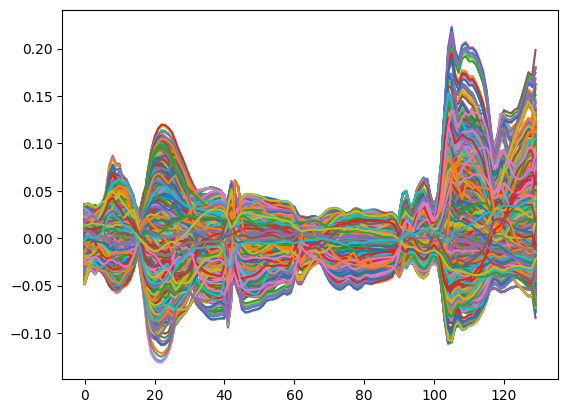

In [3]:
train_df=pd.DataFrame(X_train)
train_df.iloc[:,:].T.plot(legend=False)

c:\blue_berry\python_pipeline\scripts\env\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/3000, Loss: 0.8171, Val Loss: 0.6873
Epoch 2/3000, Loss: 0.7450, Val Loss: 0.7331
Epoch 3/3000, Loss: 0.7249, Val Loss: 0.6301
Epoch 4/3000, Loss: 0.6976, Val Loss: 0.7158
Epoch 5/3000, Loss: 0.6851, Val Loss: 0.6489
Epoch 6/3000, Loss: 0.6730, Val Loss: 0.6328
Epoch 7/3000, Loss: 0.6742, Val Loss: 0.6436
Epoch 8/3000, Loss: 0.6504, Val Loss: 0.6121
Epoch 9/3000, Loss: 0.6622, Val Loss: 0.6125
Epoch 10/3000, Loss: 0.6502, Val Loss: 0.6209
Epoch 11/3000, Loss: 0.6399, Val Loss: 0.6038
Epoch 12/3000, Loss: 0.6485, Val Loss: 0.6094
Epoch 13/3000, Loss: 0.6352, Val Loss: 0.6109
Epoch 14/3000, Loss: 0.6358, Val Loss: 0.6079
Epoch 15/3000, Loss: 0.6424, Val Loss: 0.6129
Epoch 16/3000, Loss: 0.6517, Val Loss: 0.6282
Epoch 17/3000, Loss: 0.6559, Val Loss: 0.6213
Epoch 18/3000, Loss: 0.6423, Val Loss: 0.6044
Epoch 19/3000, Loss: 0.6508, Val Loss: 0.6116
Epoch 20/3000, Loss: 0.6328, Val Loss: 0.6116
Epoch 21/3000, Loss: 0.6382, Val Loss: 0.6139
Epoch 22/3000, Loss: 0.6431, Val Loss: 0.61

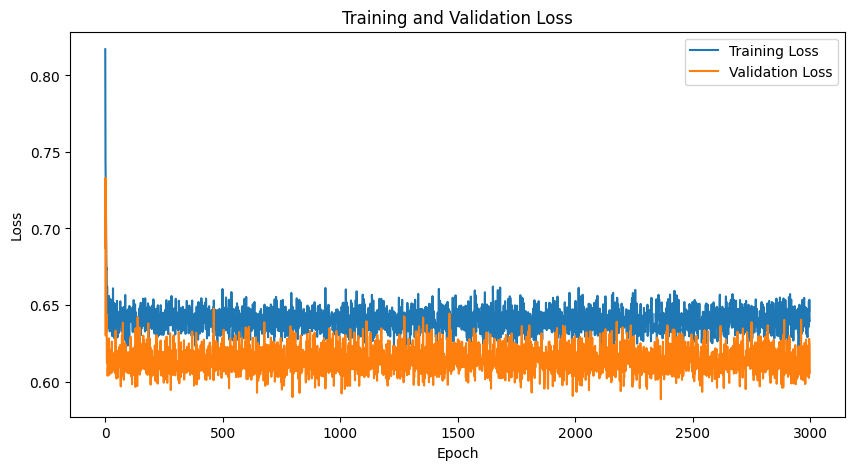

In [4]:

# Define the MLP model
class SpectralMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob, device):
        super(SpectralMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.bn1 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.bn2 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2).to(device)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2).to(device)
        self.output = nn.Linear(hidden_dim // 2, output_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Initialize the model with specific hyperparameters
input_dim = X_train.shape[1]
hidden_dim = 64
dropout_prob = 0.2
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 3000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SpectralMLP(input_dim, 1, hidden_dim, dropout_prob, device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=0, verbose=False)

# Convert data to tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_train_reg.values if isinstance(y_train_reg, pd.Series) else y_train_reg, dtype=torch.float32).view(-1, 1).to(device)
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

X_val_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_val_tensor =torch.tensor(y_test_reg if isinstance(y_test_reg, np.ndarray) else y_test_reg.values, dtype=torch.float32).view(-1, 1).to(device)

# Training loop
train_loss = []
val_loss = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        logits = model(x_batch)
        loss = torch.sqrt(criterion(logits, y_batch))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(loader)
    train_loss.append(avg_loss)

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val_tensor)
        val_loss_value = torch.sqrt(criterion(val_logits, y_val_tensor)).item()
    val_loss.append(val_loss_value)
    model.train()

    scheduler.step(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss_value:.4f}')

# Predict on test data
model.eval()
with torch.no_grad():
    y_pred = model(X_val_tensor).cpu().numpy().flatten()

# Evaluate the model
r2 = r2_score(y_test_reg, y_pred)
print(f'R2 Score on test data: {r2}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [8]:
# grid searching

# Define the MLP model
class SpectralMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, dropout_prob, device):
        super(SpectralMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim).to(device)
        self.bn1 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.bn2 = nn.BatchNorm1d(hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim // 2).to(device)
        self.bn3 = nn.BatchNorm1d(hidden_dim // 2).to(device)
        self.fc4 = nn.Linear(hidden_dim // 2, hidden_dim // 2).to(device)
        self.bn4 = nn.BatchNorm1d(hidden_dim // 2).to(device)
        self.fc5 = nn.Linear(hidden_dim // 2, hidden_dim // 4).to(device)
        self.bn5 = nn.BatchNorm1d(hidden_dim // 4).to(device)
        self.fc6 = nn.Linear(hidden_dim // 4, hidden_dim // 4).to(device)
        self.bn6 = nn.BatchNorm1d(hidden_dim // 4).to(device)
        self.output = nn.Linear(hidden_dim // 4, output_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.dropout(x)
        # x = self.relu(self.bn6(self.fc6(x)))
        x = self.dropout(x)
        x = self.output(x)
        return x

# Define the custom PyTorch model wrapper
class SpectralMLPWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim = 130, hidden_dim=32, dropout_prob=0.2, learning_rate=0.001, weight_decay =0.0001, num_epochs =1000 ,batch_size=64):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout_prob = dropout_prob
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SpectralMLP(input_dim, 1, hidden_dim, dropout_prob, device=self.device).to(self.device)
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.1, patience=4, verbose=False)
        self.train_loss = []
        self.val_loss = []

    def fit(self, X, y, X_val=None, y_val=None):
        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y if isinstance(y, np.ndarray) else y.values, dtype=torch.float32).view(-1, 1).to(self.device)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(self.device)
            y_val_tensor = torch.tensor(y_val if isinstance(y_val, np.ndarray) else y_val.values, dtype=torch.float32).view(-1, 1).to(self.device)
            val_dataset = TensorDataset(X_val_tensor,y_val_tensor)
            valLoader = DataLoader(val_dataset,batch_size=self.batch_size,shuffle=True) 
        self.model.train()
        for epoch in range(self.num_epochs):
            running_loss = 0.0
            for x_batch, y_batch in loader:
                self.optimizer.zero_grad()
                logits = self.model(x_batch)
                loss = torch.sqrt(self.criterion(logits, y_batch))
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()
            avg_loss = running_loss / len(loader)
            self.train_loss.append(avg_loss)

            if X_val is not None and y_val is not None:
                self.model.eval()
                with torch.no_grad():
                    running_val_loss = 0.0
                    for val_x_batch, val_y_batch in valLoader: 
                        val_logits = self.model(val_x_batch)
                        val_loss = torch.sqrt(self.criterion(val_logits, val_y_batch)).item()
                        running_val_loss += val_loss
                    avg_val_loss=running_val_loss/len(valLoader)
                    self.val_loss.append(avg_val_loss)
                self.model.train()

            self.scheduler.step(avg_loss)
            print(f'Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}' if X_val is not None and y_val is not None else f'Epoch {epoch+1}/{self.num_epochs}, Loss: {avg_loss:.4f}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            predictions = self.model(X_tensor).cpu().numpy().flatten()
        return predictions

# Define the parameter grid for GridSearchCV
param_grid = {
    'hidden_dim': [32,64,128],
    'dropout_prob': [0.2,0.3,0.5,0.6],
    'learning_rate': [0.0001,0.001,0.0025,0.005,0.0075,0.01],
    'weight_decay': [0.0001,0.0005],
    'num_epochs': [1000,3000],
    'batch_size':[64,128,256]
}

# Create the GridSearchCV object
scorer = make_scorer(r2_score)
grid_search = GridSearchCV(estimator=SpectralMLPWrapper(input_dim=X_train.shape[1]),
                           param_grid=param_grid,
                           scoring=scorer,
                           cv=5,
                           verbose=2,
                           n_jobs=-1)



# Fit the model
grid_search.fit(X_train, y_train_reg, X_val=X_test, y_val=y_test_reg)

# Best parameters
print("Best parameters found: ", grid_search.best_params_)

# Best estimator
best_mlp = grid_search.best_estimator_

# Predict on test data
y_pred = best_mlp.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test_reg, y_pred)
print(f'R2 Score on test data: {r2}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(best_mlp.train_loss, label='Training Loss')
plt.plot(best_mlp.val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Fitting 5 folds for each of 864 candidates, totalling 4320 fits


In [4]:
#transformer training
train_loss = []
val_loss = []

for epoch in range(50):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(loader, 0):
        # basic training loop
        x_batch, y_class_batch, y_reg_batch = data
        optimizer.zero_grad()
        combined_loss, loss_class, loss_reg = loss_wrapper(x_batch.to(device), y_class_batch.to(device), y_reg_batch.to(device))
        loss_reg.backward()
        optimizer.step()

        running_loss += loss_reg.item()
        
        if i % 10 == 0:  # Every 10 mini-batches...
            # Check against the validation set
            running_vloss = 0.0
            combined_model.eval()  # Put the model in evaluation mode
            with torch.no_grad():  # Don't need to track gradients for validation
                for j, vdata in enumerate(val_loader, 0):
                    vx_batch, vy_class_batch, vy_reg_batch = vdata
                    vcombined_loss, vloss_class, vloss_reg = loss_wrapper(vx_batch.to(device), vy_class_batch.to(device), vy_reg_batch.to(device))
                    running_vloss += vloss_reg.item()
            
            combined_model.train()  # Put the model back in training mode
            
            avg_loss = running_loss / 1000
            avg_vloss = running_vloss / len(val_loader)
            
            # Append the average loss to the lists
            train_loss.append(avg_loss)
            val_loss.append(avg_vloss)

            # Log the running loss averaged per batch
            # writer.add_scalars('Training vs. Validation Loss',
            #                    {'Training': avg_loss, 'Validation': avg_vloss},
            #                    epoch * len(train_loader) + i)

            running_loss = 0.0

    print(f'Epoch {epoch} ---- train loss: {avg_loss} --- val loss: {avg_vloss}')

print('Finished Training')

# writer.flush()


NameError: name 'loader' is not defined

In [ ]:
batch = next(iter(training_loader))
yhat = combined_model(batch[0]) # Give dummy batch to forward().
make_dot(yhat, params=dict(list(combined_model.named_parameters())))

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

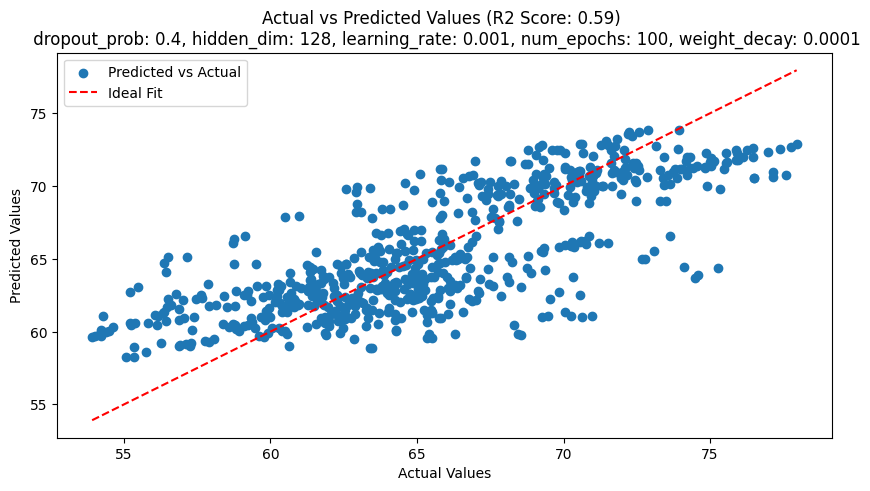

R2 Score: 0.59


In [24]:

from sklearn.metrics import r2_score

# Switch model to evaluation mode
model.eval()

# Generate some test data
# test_features = torch.randn(20, 177).to(device)
# test_labels = torch.randint(0, 3, (20,)).to(device)
# test_regression_targets = torch.randn(20, 1).to(device)

# Make predictions
with torch.no_grad():

    reg_outputs = model(torch.Tensor(X_test).to(device=device))
    
# Convert tensors to numpy arrays for plotting



y_actual = y_test_reg
y_pred = reg_outputs.detach().cpu().numpy()

y_pred = analysis.scalers["RWC"].inverse_transform(y_pred)
y_true_test = analysis.scalers["RWC"].inverse_transform(y_actual.values.reshape(-1, 1))

# Calculate R-squared value
r2 = r2_score(y_true_test, y_pred)

# Plot the results
plt.figure(figsize=(10, 5))
plt.scatter(y_true_test, y_pred, label='Predicted vs Actual')
plt.plot([y_true_test.min(), y_true_test.max()], [y_true_test.min(), y_true_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values (R2 Score: {r2:.2f}) \n dropout_prob: 0.4, hidden_dim: 128, learning_rate: 0.001, num_epochs: 100, weight_decay: 0.0001')
plt.legend()
plt.show()

print(f"R2 Score: {r2:.2f}")


In [21]:
#save model
torch.save(best_mlp.model.state_dict(), 'best_spectral_mlp.pth')


best_params = grid_search.best_params_
loaded_model = SpectralMLP(input_dim=X_train.shape[1], 
                           output_dim=1, 
                           hidden_dim=best_params['hidden_dim'], 
                           dropout_prob=best_params['dropout_prob'], 
                           device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Load the saved state_dict
loaded_model.load_state_dict(torch.load('best_spectral_mlp.pth'))

# Set the model to evaluation mode
loaded_model.eval()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
[2 2 0 0 1 2 1 1 0 0 2 1 2 2 0 0 1 1 0 1 2 2 0 0 1 0 0 1 1 1 1 0 2 2 2 2 0
 1 1 0 0 1 1 2 0 2 0 1 0 2 2 1 0 2 2 0 0 2 1 1 0 0 0 0 2 2]


Inception try

In [ ]:
import os
os.environ["PATH"] += os.pathsep + "C:\Program Files (x86)\Graphviz-11.0.0-win64\bin"

In [ ]:
from Inception_model import Inception
from utils import init_weights,Make_one_one_plot,benchmark,train_One_epoch,evaluate

In [ ]:
model=Inception()
model = model.apply(init_weights)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(),lr=0.00316) 

scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0002633, max_lr=0.00316,step_size_up=3664, 
                                              step_size_down=None, mode='exp_range',gamma=0.99994,scale_fn=None,
                                              cycle_momentum=False)

In [ ]:
training_losses=[]
training_lrs=[]
validation_losses=[]
best_valid=1000
for epoch in range(100):
    training_loss,lrs=train_One_epoch(model,training_loader,optimizer,loss_fn)  
    training_losses.append(training_loss)
    training_lrs.append(lrs)
    #Evaluate the model
    validation_loss=evaluate(model,val_loader,loss_fn)
    validation_losses.append(validation_loss)

    print(f"[{epoch+1}] Training loss: {training_loss:.3f}\t Validation loss: {validation_loss:.3f}")
    
    #Check the losses and save the model
    if validation_loss < best_valid:
        best_valid = validation_loss
        print("New Best model found")
#         torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'train_loss':training_loss,
#                 'val_loss':validation_loss
#                 },f"../Deep learning approach/Weights/test_wts.pt")
    


ValueError: too many values to unpack (expected 2)

In [135]:
class SpectralPatchEmbedding(nn.Module):
    def __init__(self, patch_size: int, embedding_dim: int, device: str) -> None:
        super(SpectralPatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embedding = nn.Linear(patch_size, embedding_dim, device=device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'SpectralPatchEmbedding input shape: {x.shape}')
        x = x.unfold(1, self.patch_size, self.patch_size).contiguous()
        print(f'After unfold: {x.shape}')
        x = x.view(x.size(0), -1, self.patch_size)
        print(f'After view: {x.shape}')
        x = self.embedding(x)
        print(f'After embedding: {x.shape}')
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model,device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'in positionencoding {x.shape}')
        x = x + self.pe[:x.size(1)]
        print(f'after positionencoding {x[0,0].shape}')
        return x









dummy_input = torch.randn(1,177).to(device)


class models(nn.Module):
    def __init__(self, patch_size: int, embedding_dim: int, device: str,num_heads: int, dim_feedforward: int,
                 num_encoder_layers: int, activation_fn=F.gelu) -> None:
        super(models,self).__init__()
        self.spectralEmbedding= SpectralPatchEmbedding(patch_size = patch_size, embedding_dim= embedding_dim, device=device)
        self.positionalEncoding= PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,
                                                    activation=activation_fn, device=device,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, x: torch.tensor):
        x= self.spectralEmbedding(x)
        x= self.positionalEncoding(x)
        # x= x.permute(1,0,2)
        x= self.transformer_encoder(x)
        print(f'After Transformer: {x.shape}')
        return x
model= models(patch_size=64, embedding_dim= 128, device=device,num_heads=1, dim_feedforward=1,num_encoder_layers=1)
# x=nn.Linear(8,64,device="cuda")
# print(x(dummy_input))
# print(model(dummy_input))
summary(model, input_size=(1,177))

SpectralPatchEmbedding input shape: torch.Size([1, 177])
After unfold: torch.Size([1, 2, 64])
After view: torch.Size([1, 2, 64])
After embedding: torch.Size([1, 2, 128])
in positionencoding torch.Size([1, 2, 128])
after positionencoding torch.Size([128])
After Transformer: torch.Size([1, 2, 128])


Layer (type:depth-idx)                        Output Shape              Param #
models                                        [1, 2, 128]               --
├─SpectralPatchEmbedding: 1-1                 [1, 2, 128]               --
│    └─Linear: 2-1                            [1, 2, 128]               8,320
├─PositionalEncoding: 1-2                     [1, 2, 128]               --
├─TransformerEncoder: 1-3                     [1, 2, 128]               --
│    └─ModuleList: 2-2                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 2, 128]               66,945
Total params: 75,265
Trainable params: 75,265
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.04
Estimated Total Size (MB): 0.05

In [136]:
dict(model.named_modules())

{'': models(
   (spectralEmbedding): SpectralPatchEmbedding(
     (embedding): Linear(in_features=64, out_features=128, bias=True)
   )
   (positionalEncoding): PositionalEncoding()
   (transformer_encoder): TransformerEncoder(
     (layers): ModuleList(
       (0): TransformerEncoderLayer(
         (self_attn): MultiheadAttention(
           (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
         )
         (linear1): Linear(in_features=128, out_features=1, bias=True)
         (dropout): Dropout(p=0.1, inplace=False)
         (linear2): Linear(in_features=1, out_features=128, bias=True)
         (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
         (dropout1): Dropout(p=0.1, inplace=False)
         (dropout2): Dropout(p=0.1, inplace=False)
       )
     )
   )
 ),
 'spectralEmbedding': SpectralPatchEmbedding(
   (embedding): Linear(in_features=64, out_fe

In [48]:
# Define a hook function to collect intermediate activations
activations = {}
def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks for intermediate layers
# modelv2.featureExtractor.spectralEmbedding.register_forward_hook(get_activation('spectralEmbedding'))
# modelv2.featureExtractor.positionalEncoding.register_forward_hook(get_activation('positionalEncoding'))
# modelv2.featureExtractor.transformerEncoder.register_forward_hook(get_activation('featureExtractor'))
# modelv2.classificationHead.fc1.register_forward_hook(get_activation('classHeadfeatures_fc1'))
# modelv2.classificationHead.fc2.register_forward_hook(get_activation('classHeadfeatures_fc2'))
# modelv2.classificationHead.fc3.register_forward_hook(get_activation('classHeadfeatures_fc3'))
# modelv2.RegressionHead.fc1.register_forward_hook(get_activation('RegressionHead_fc1'))
# modelv2.RegressionHead.fc2.register_forward_hook(get_activation('RegressionHead_fc2'))
# modelv2.RegressionHead.fc3.register_forward_hook(get_activation('RegressionHead_fc3'))
# modelv2.RegressionHead.fc4.register_forward_hook(get_activation('RegressionHead_fc4'))
mlp.fc1.register_forward_hook(get_activation('fc1'))
mlp.fc2.register_forward_hook(get_activation('fc2'))
mlp.fc3.register_forward_hook(get_activation('fc3'))
# mlp.fc4.register_forward_hook(get_activation('fc4'))
# mlp.fc5.register_forward_hook(get_activation('fc5'))
# Forward pass with hooks
batch = next(iter(training_loader))
output = mlp(batch[0].to(device=device))

Layer: fc1, Shape: torch.Size([32, 64])


C:\Users\mzr0134\AppData\Local\Temp\ipykernel_9264\1276312506.py:21: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


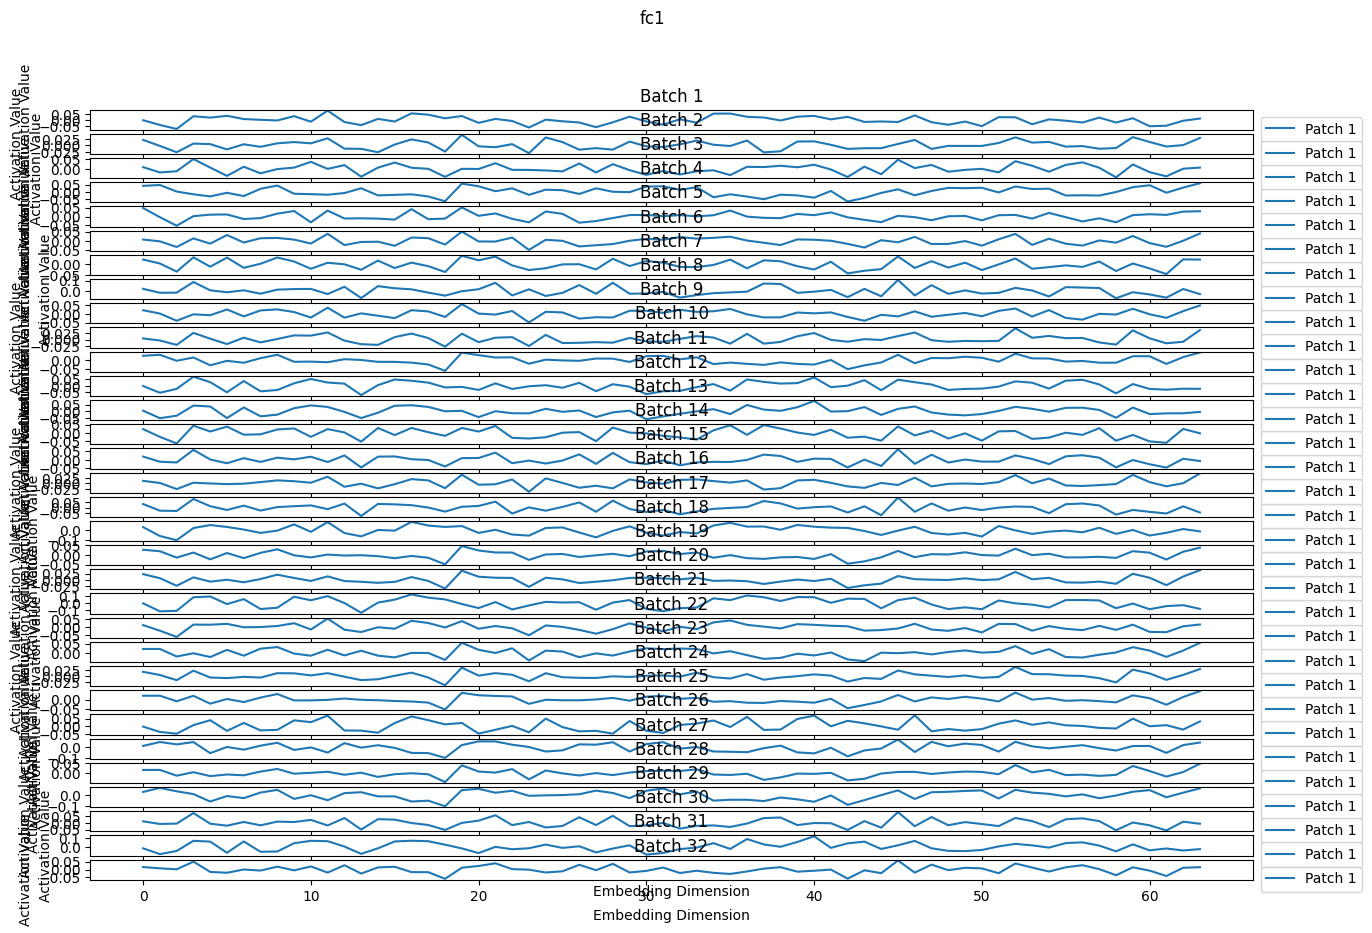

Layer: fc2, Shape: torch.Size([32, 32])


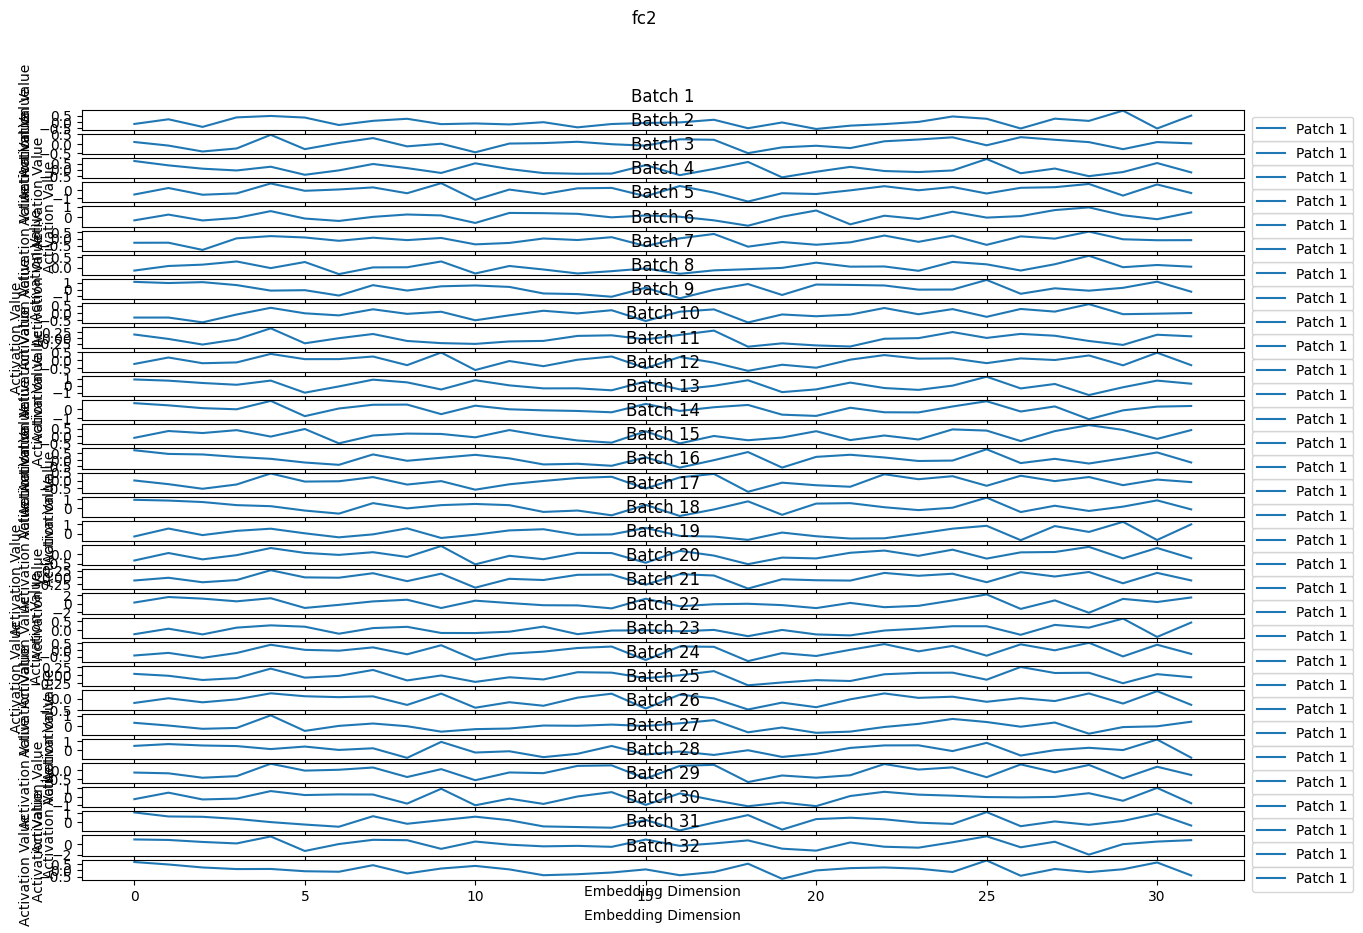

Layer: fc3, Shape: torch.Size([32, 16])


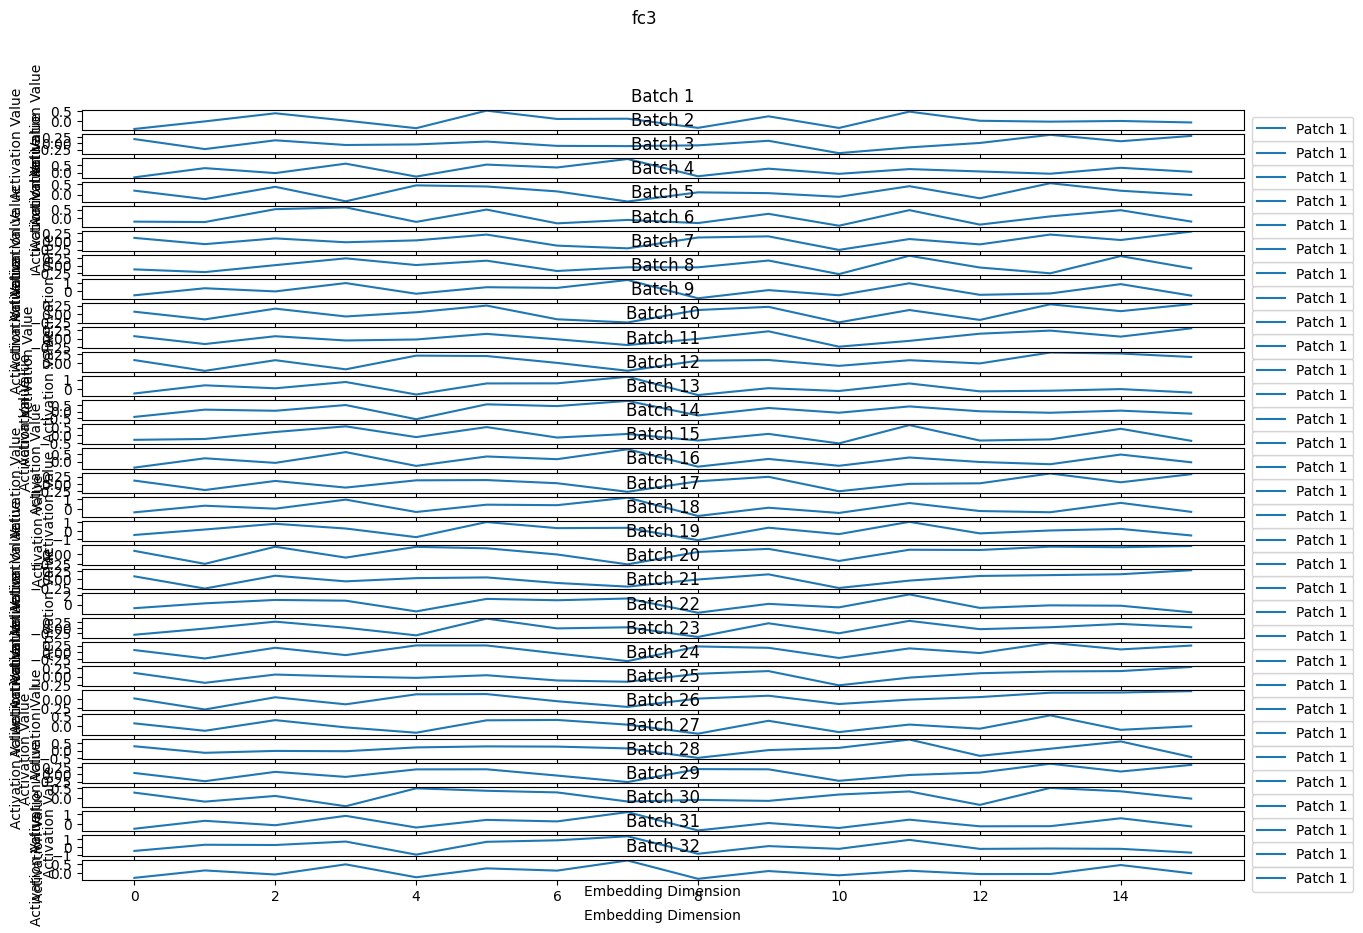

In [49]:

def hidden_layer_viz(activations):
    """
    This function will plot the activations of hidden layers.
    Input: activations --> {'layer_name': weights # batch x patch_size x embedding_dim}
    """
    for layer_name, activation in activations.items():
        print(f'Layer: {layer_name}, Shape: {activation.shape}')
    
        fig, axes = plt.subplots(activation.shape[0], 1, figsize=(15, 10))
        fig.suptitle(layer_name)

        if len(activation.squeeze().shape) == 2:  # If PATCH size is 1
            for i in range(activation.shape[0]):
                # Reshape the activation for each batch item to plot as line plots
                batch_activation = activation[i].cpu().numpy().squeeze()
                axes[i].plot(batch_activation, label='Patch 1')
                axes[i].set_title(f'Batch {i+1}')
                axes[i].set_xlabel('Embedding Dimension')
                axes[i].set_ylabel('Activation Value')
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
        else:
            # For multiple patches
            for i in range(activation.shape[0]):
                # Reshape the activation for each batch item to plot as line plots
                batch_activation = activation[i].cpu().numpy()
                for j in range(activation.shape[1]):
                    axes[i].plot(batch_activation[j], label=f'Patch {j+1}')
                axes[i].set_title(f'Batch {i+1}')
                axes[i].set_xlabel('Embedding Dimension')
                axes[i].set_ylabel('Activation Value')
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1)
            plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()
hidden_layer_viz(activations)

In [171]:
#with_patch
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import typing as ty
from torch import Tensor
import math

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, patch_size: int, embedding_dim: int,token_bias: bool) -> None:
        super().__init__()
        assert d_numerical > patch_size
        self.patch_size = patch_size
        self.weight = nn.Parameter(Tensor(d_numerical // patch_size + 1, patch_size, embedding_dim))  # +1 for [CLS] token
        self.bias = nn.Parameter(Tensor(d_numerical // patch_size + 1, embedding_dim)) if bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.kaiming_uniform_(self.bias, a=math.sqrt(5))

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: Tensor) -> Tensor:
        # Divide the numerical data into patches
        print(f'before patch {x_num.shape}')
        x_num = x_num.unfold(1, self.patch_size, self.patch_size)
        print(f'after patch {x_num.shape}')
        # Add [CLS] token
        cls_token = torch.ones(x_num.size(0), 1, self.patch_size, device=x_num.device)
        print(f'cls_token {cls_token.shape}')
        x_num = torch.cat([cls_token, x_num], dim=1)
        print(f'after class {x_num.shape}')
        print(f'Weight {self.weight.shape}')
        # Apply the embedding using the weight and bias tensors
        x = torch.einsum('bpn,pnd->bpd', x_num, self.weight)  # Batch, Patches, Patch Size -> Batch, Patches, Token Dim
        print(f'self.bias {self.bias.shape}')
        print(f'x after {x.shape}')
        if self.bias is not None:
            x = x + self.bias[None]
        return x


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, device: str, max_len: int = 5000, base: float = 10000.0) -> None:
        super(PositionalEncoding, self).__init__()
        self.max_len = max_len
        self.base = base
        
        pe = torch.zeros(max_len, d_model,device=device)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(base) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        print(f'in positionencoding {x.shape}')
        x = x + self.pe[:x.size(1)]
        print(f'after positionencoding {x[0,0].shape}')
        return x


dummy_input = torch.randn(1,177).to(device)


class models(nn.Module):
    def __init__(self,d_numerical: int, patch_size: int, embedding_dim: int, device: str,num_heads: int, dim_feedforward: int,
                 num_encoder_layers: int,token_bias:bool, activation_fn=F.gelu,) -> None:
        super(models,self).__init__()
        self.spectralEmbedding= Tokenizer(d_numerical=d_numerical, patch_size=patch_size,embedding_dim= embedding_dim, token_bias=token_bias)
        self.positionalEncoding= PositionalEncoding(embedding_dim, device=device)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=dim_feedforward,
                                                    activation=activation_fn, device=device,batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, x: torch.tensor):
        x= self.spectralEmbedding(x)
        x= self.positionalEncoding(x)
        x= self.transformer_encoder(x)
        print(f'After Transformer: {x.shape}')
        return x
model= models(d_numerical=177,patch_size=8, embedding_dim= 128, device=device,num_heads=1, 
              dim_feedforward=1,num_encoder_layers=1,token_bias=True)
# x=nn.Linear(8,64,device="cuda")
# print(x(dummy_input))
# print(model(dummy_input))
summary(model, input_size=(1,177))


# # Sample usage:
# if __name__ == "__main__":
#     d_numerical = 177
#     patch_size = 8
#     d_token = 16
#     bias = True

#     tokenizer = Tokenizer(d_numerical, patch_size, d_token, bias)

#     # Example numerical data: batch of 2 samples, each with 20 features
#     x_num = torch.randn(2, d_numerical)
#     output = tokenizer(x_num)
#     print("Tokenizer output shape:", output.shape)
#     print(summary(tokenizer,input_size=(1,177)))

before patch torch.Size([1, 177])
after patch torch.Size([1, 22, 8])
cls_token torch.Size([1, 1, 8])
after class torch.Size([1, 23, 8])
Weight torch.Size([23, 8, 128])
self.bias torch.Size([23, 128])
x after torch.Size([1, 23, 128])
in positionencoding torch.Size([1, 23, 128])
after positionencoding torch.Size([128])
After Transformer: torch.Size([1, 23, 128])


Layer (type:depth-idx)                        Output Shape              Param #
models                                        [1, 23, 128]              --
├─Tokenizer: 1-1                              [1, 23, 128]              26,496
├─PositionalEncoding: 1-2                     [1, 23, 128]              --
├─TransformerEncoder: 1-3                     [1, 23, 128]              --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [1, 23, 128]              66,945
Total params: 93,441
Trainable params: 93,441
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.03
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.11
Estimated Total Size (MB): 0.20

In [140]:
#without_patch
import torch
import torch.nn as nn
import torch.nn.init as nn_init
import typing as ty
from torch import Tensor
import math

class Tokenizer(nn.Module):
    def __init__(self, d_numerical: int, d_token: int, bias: bool) -> None:
        super().__init__()
        self.weight = nn.Parameter(Tensor(d_numerical + 1, d_token))  # +1 for [CLS] token
        self.bias = nn.Parameter(Tensor(d_numerical + 1, d_token)) if bias else None

        # Initialization inspired by nn.Linear
        nn_init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            nn_init.zeros_(self.bias)

    @property
    def n_tokens(self) -> int:
        return len(self.weight)

    def forward(self, x_num: Tensor) -> Tensor:
        print(f'x_m {x_num.shape}')
        x_num = torch.cat(
            [torch.ones(len(x_num), 1, device=x_num.device)] + [x_num], dim=1
        )  # Add [CLS] token
        print(f'weight {self.weight.shape}')
        x = self.weight[None] * x_num[:, :, None]
        if self.bias is not None:
            x = x + self.bias[None]
        return x

# Sample usage:
if __name__ == "__main__":
    d_numerical = 177
    d_token = 16
    bias = True

    tokenizer = Tokenizer(d_numerical, d_token, bias)

    # Example numerical data: batch of 2 samples, each with 10 features
    x_num = torch.randn(2, d_numerical)
    output = tokenizer(x_num)
    print("Tokenizer output shape:", output.shape)
    print(summary(tokenizer,input_size=(1,177)))

x_m torch.Size([2, 177])
weight torch.Size([178, 16])
Tokenizer output shape: torch.Size([2, 178, 16])
x_m torch.Size([1, 177])
weight torch.Size([178, 16])
Layer (type:depth-idx)                   Output Shape              Param #
Tokenizer                                [1, 178, 16]              5,696
Total params: 5,696
Trainable params: 5,696
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.02
Estimated Total Size (MB): 0.05
